In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections
import random
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation, Rescaling
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.initializers import HeNormal

In [2]:
classes = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]


checkpoints_path = 'best_model.h5'

In [3]:
def load_data(data_file):
    print('Loading data ...')
    with open(data_file, 'rb') as f:
        pickle_data = pickle.load(f)
        return pickle_data[0], pickle_data[1]

In [4]:
data_file = 'image_data48.p'
images, labels = load_data(data_file)

n_samples = labels.shape[0]
print('Total samples:', n_samples)
print('images shape:', images.shape)
print('labels shape:', labels.shape)

Loading data ...
Total samples: 15339
images shape: (15339, 48, 48)
labels shape: (15339,)


# Explore the data

In [5]:
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

num_classes = len(emotions)

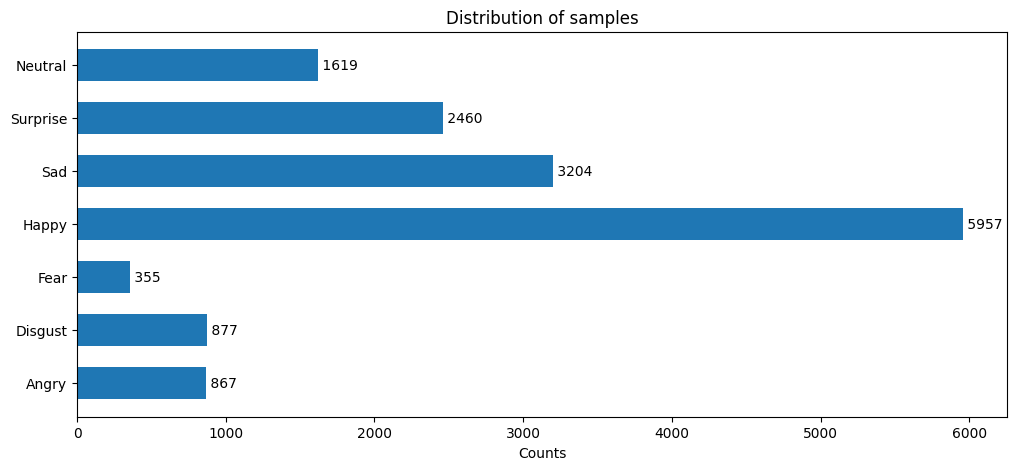

In [6]:
def plot_sample_distribution(labels):
    classes, cnts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(12, 5))
    plt.barh(list(emotions.values()), cnts, height=0.6)
    for i, v in enumerate(cnts):
        plt.text(v, i, ' '+str(v), va='center')
    plt.xlabel('Counts')
    plt.title("Distribution of samples")

plot_sample_distribution(labels)

In [7]:
def show_images(images, labels, col=7):
    n = images.shape[0]
    row = int(np.ceil(n / col))
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(row, col, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(emotions[labels[i]])
        plt.xticks([]), plt.yticks([])
    plt.show()

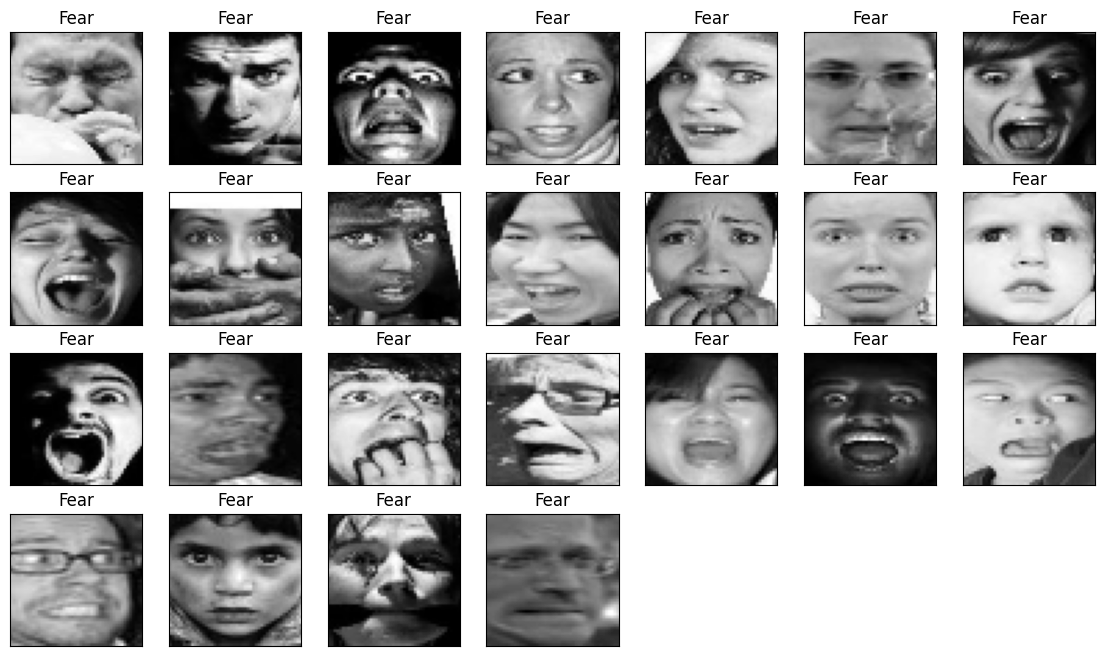

In [8]:
# Id is the emotion number, ex: 1 is Disgust

id = 2

def show_one_emotion(images, labels, id, start=0, num=25):
    image_x = images[labels==id]
    label_x = labels[labels==id]
    show_images(image_x[start:start+num], label_x[start:start+num])

show_one_emotion(images, labels, id=id)

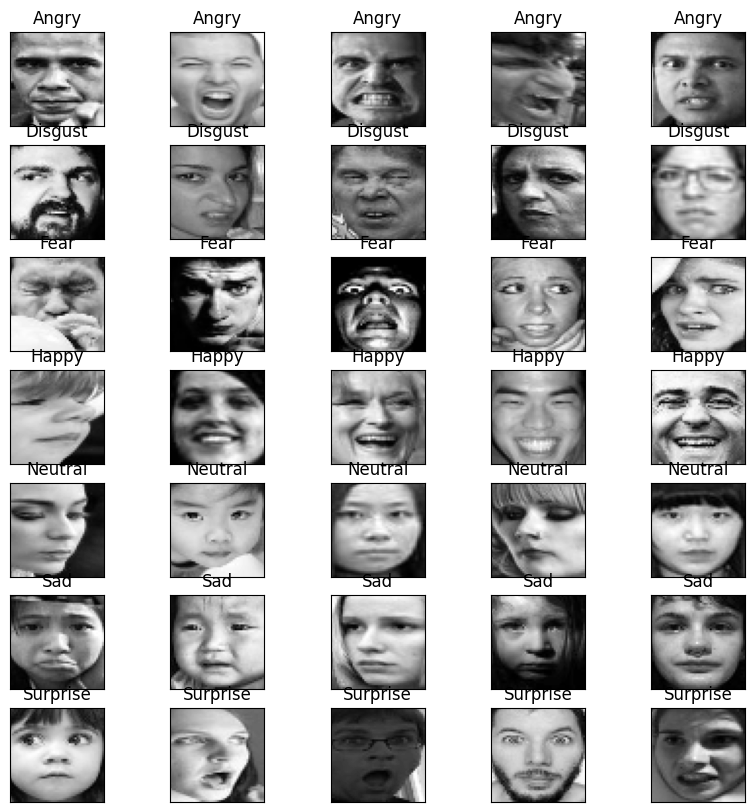

In [9]:


def show_images(images, labels, col=5):
    n = col * 7
    fig = plt.figure(figsize=(2*col, 10))
    for i, class_name in enumerate(classes):
        class_images = images[labels == i][:5]
        for j in range(col):
            fig.add_subplot(7, col, i*col+j+1)
            if j < len(class_images):
                plt.imshow(class_images[j], cmap='gray')
                plt.title(class_name)
            plt.xticks([]), plt.yticks([])
    plt.show()

show_images(images, labels)


# Split dataset

In [10]:
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])
print('Test samples:', label_test.shape[0])

Training samples: 9816
Validation samples: 2455
Test samples: 3068


# **Upsamling training data**

In [11]:
def adjust_class_distribution(x, y, class_weights):
    n_samples, _, _, _ = x.shape
    class_counts = np.bincount(y)
    class_weight_ratios = {class_id : class_weights[class_id] / class_counts[class_id] for class_id in class_weights.keys()}
    weights = np.zeros(n_samples, dtype=np.float32)
    for i, class_id in enumerate(y):
        weights[i] = class_weight_ratios[class_id]
    return x, y, weights


In [43]:
def upsampling(x, y, strategy):
    (n, w, h) = x.shape
    sm = SMOTE(sampling_strategy=strategy, random_state=42)
    x_flat = x.reshape((n,-1))
    x_up, y_up = sm.fit_resample(x_flat, y)
    n_up = x_up.shape[0]
    x_up = x_up.reshape((n_up,w,h))

    return x_up, y_up

In [20]:
collections.Counter(label_train)

Counter({6: 1040, 3: 3831, 5: 1590, 1: 553, 4: 2007, 0: 550, 2: 245})

In [21]:
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

NameError: name 'upsampling' is not defined

In [46]:
collections.Counter(label_train_up)

Counter({6: 3831, 3: 3831, 5: 3831, 1: 3831, 4: 3831, 0: 3831, 2: 3831})

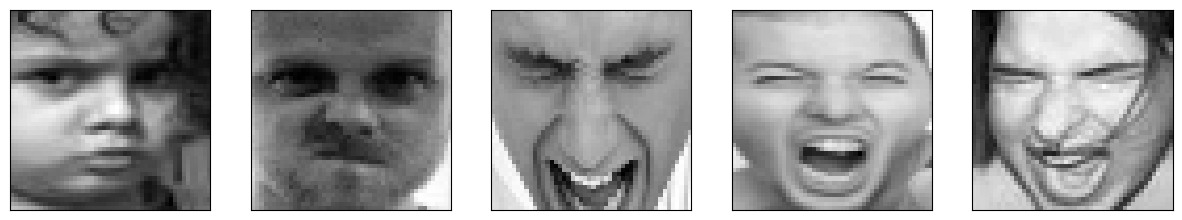

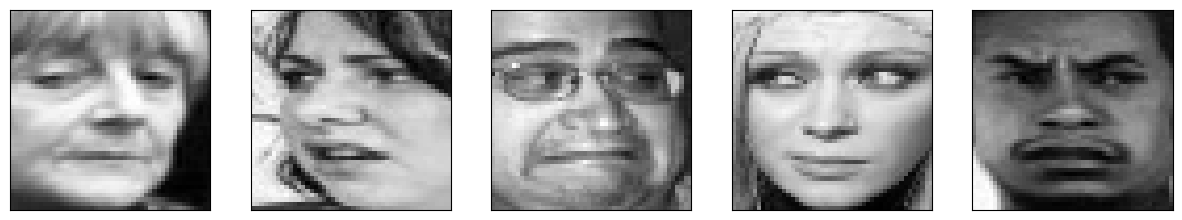

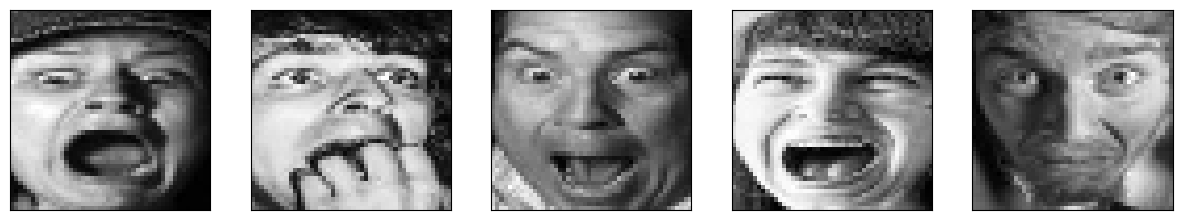

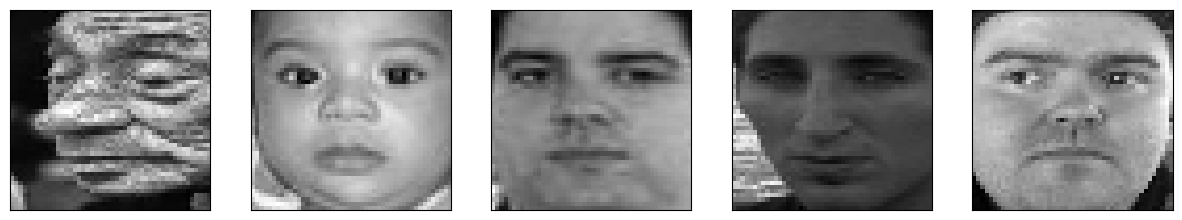

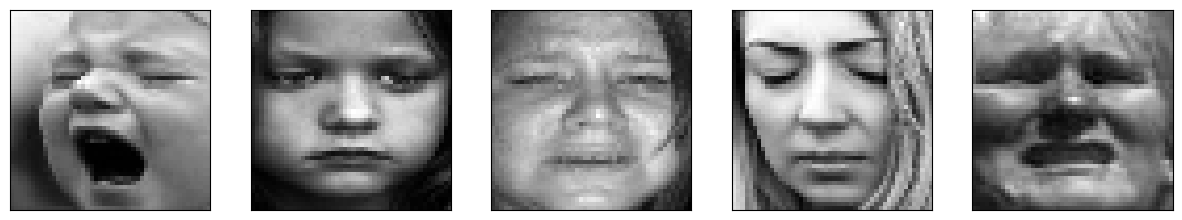

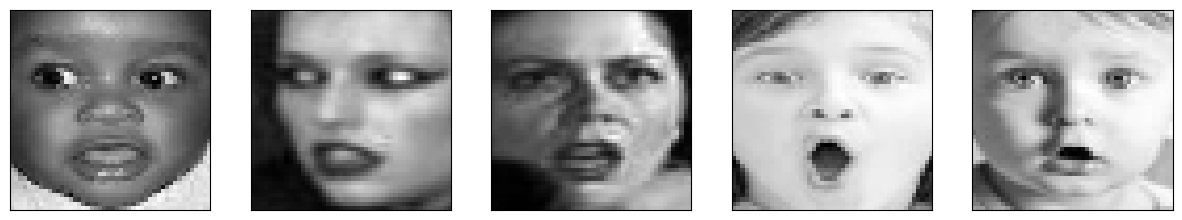

In [47]:
def show_one_emotion(images, labels, id, start=0, num=5):
    fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(15, 15))
    axes = axes.flatten()
    for i in range(start, start+num):
        img = images[labels == id][i]
        axes[i-start].imshow(img, cmap="gray")
        axes[i-start].set_xticks(())
        axes[i-start].set_yticks(())
    plt.show()

num_classes = len(np.unique(label_train_up))

for i in range(num_classes):
    if i == 3:
        continue
    show_one_emotion(image_train_up, label_train_up, id=i, start=0, num=5)


# Utils

In [14]:
def one_hot_encoding(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes)

In [15]:
def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize)
    return x

In [16]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y

In [17]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model '+name)
        plt.legend()
    plt.show()

In [18]:
def evaluate_class(model, x_test, y_test):
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    for i in range(num_classes):
        x = x_test[labels==i]
        y = y_test[labels==i]
        loss, acc = model.evaluate(x,  y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[i], acc))
    print('-'*23)
    loss, acc = model.evaluate(x_test,  y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))

# Model

In [19]:
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)
x_test, y_test = pre_processing(image_test, label_test, num_classes)

train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

NameError: name 'image_train_up' is not defined

In [27]:
epochs = 200

cp = ModelCheckpoint(filepath = checkpoints_path, save_weights_only=False, monitor='val_accuracy',  mode='max', save_best_only=True,  verbose=1)

#Early Stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

#Learning rate reduction
lr = ReduceLROnPlateau(monitor = 'val_loss',patience = 10, verbose = 1,factor = 0.50, min_lr = 1e-10)

In [28]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
        
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[lr, es, cp])

In [ ]:
plot_metrics(history)

In [29]:
# model.load_weights(model.checkpoint_path)
model = load_model("saved_models/model_RAFDB2.h5")
evaluate_class(model, x_test, y_test)

Emotion        Accuracy
-----------------------
Angry          72.4%
Disgust        42.4%
Fear           52.5%
Happy          84.4%
Sad            66.1%
Surprise       76.0%
Neutral        71.1%
-----------------------
Overall        74.0%


In [ ]:
save_model = model.save("model_RAFDB2.h5")

# Confussion Matrix

In [35]:
from sklearn.metrics import confusion_matrix

# Make predictions on test data
y_pred = model.predict(image_test)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(label_test, y_pred)
print(cm)


96/96 [==============================] - 1s 8ms/step
[[ 126    3   17    7    9    5    7]
 [  22   75    2   11   29   32    6]
 [   4    0   32    0    6    8   11]
 [  24   19   22 1008   43   57   21]
 [  10   31   12   28  441  124   21]
 [   8   23   17   23   44  370    2]
 [   3    4   19   11   32   20  219]]


              precision    recall  f1-score   support

       Angry       0.64      0.72      0.68       174
     Disgust       0.48      0.42      0.45       177
        Fear       0.26      0.52      0.35        61
       Happy       0.93      0.84      0.88      1194
     Neutral       0.73      0.66      0.69       667
         Sad       0.60      0.76      0.67       487
    Surprise       0.76      0.71      0.74       308

    accuracy                           0.74      3068
   macro avg       0.63      0.66      0.64      3068
weighted avg       0.76      0.74      0.75      3068



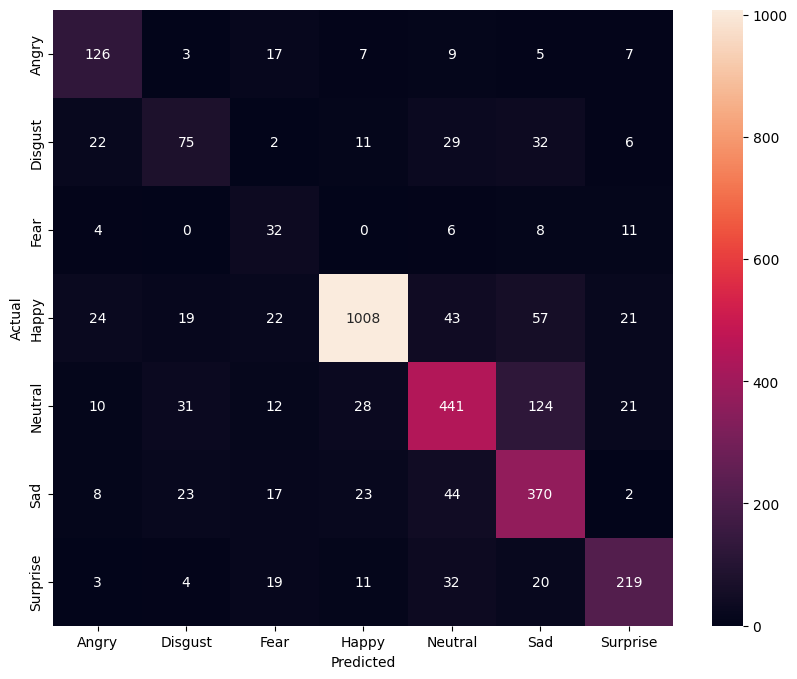

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
confusion_mtx = confusion_matrix(label_test, y_pred)

# Print the classification report
class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]  # replace with your own class names
print(classification_report(label_test, y_pred, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
confusion_mtx = confusion_matrix(label_test, y_pred)

# Calculate overall accuracy
overall_accuracy = (confusion_mtx.diagonal().sum() / confusion_mtx.sum()) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

# Calculate class accuracy
class_accuracy = {}
for i in range(len(class_names)):
    class_accuracy[class_names[i]] = (confusion_mtx[i,i] / confusion_mtx[i,:].sum()) * 100
    print(f"{class_names[i]} Accuracy: {class_accuracy[class_names[i]]:.2f}%")

Overall Accuracy: 74.02%
Angry Accuracy: 72.41%
Disgust Accuracy: 42.37%
Fear Accuracy: 52.46%
Happy Accuracy: 84.42%
Neutral Accuracy: 66.12%
Sad Accuracy: 75.98%
Surprise Accuracy: 71.10%


# Unseen Batch

In [28]:
test_data_dir = r'C:/Users/darks/Desktop/Emotion AI/Emotion Recognition/DATASETS/Batch_Ready 7'

In [29]:
# Validation images (From Train Images)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                    target_size=(48, 48),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2100 images belonging to 7 classes.


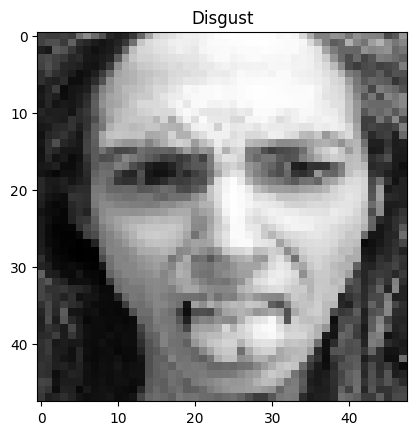

In [31]:
img, label = test_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = classes[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, classification_report

# Get the true labels and predictions for all the validation data
y_true = []
y_pred = []

for i in range(test_generator.n // batch_size):
    test_img, test_lbl = test_generator.__getitem__(i)
    pred_lbl = model.predict(test_img)
    y_true.extend(np.argmax(test_lbl, axis=1))
    y_pred.extend(np.argmax(pred_lbl, axis=1))

# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")


4/4 [==============================] - 0s 9ms/step
Accuracy: 40.33203125
Angry 293/2100 acc: 61.8
Disgust 295/2100 acc: 12.9
Fear 293/2100 acc: 45.4
Happy 288/2100 acc: 32.6
Neutral 294/2100 acc: 27.9
Sad 293/2100 acc: 49.5
Surprise 292/2100 acc: 52.4


In [33]:
# Calculate the overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Accuracy: {accuracy}")

# Calculate the accuracy for each class
class_names = test_generator.class_indices.keys()
class_accuracy = {}

for i, class_name in enumerate(class_names):
    class_idx = i
    class_mask = [True if label == class_idx else False for label in y_true]
    class_true = np.array(y_true)[class_mask]
    class_pred = np.array(y_pred)[class_mask]
    class_acc = accuracy_score(class_true, class_pred) * 100
    class_accuracy[class_name] = class_acc
    print(f"{class_name} {len(class_true)}/{test_generator.n} acc: {class_acc:.1f}")

Accuracy: 40.33203125
Angry 293/2100 acc: 61.8
Disgust 295/2100 acc: 12.9
Fear 293/2100 acc: 45.4
Happy 288/2100 acc: 32.6
Neutral 294/2100 acc: 27.9
Sad 293/2100 acc: 49.5
Surprise 292/2100 acc: 52.4


              precision    recall  f1-score   support

       Angry       0.44      0.62      0.51       293
     Disgust       0.51      0.13      0.21       295
        Fear       0.26      0.45      0.33       293
       Happy       0.79      0.33      0.46       288
     Neutral       0.55      0.28      0.37       294
         Sad       0.31      0.49      0.38       293
    Surprise       0.50      0.52      0.51       292

    accuracy                           0.40      2048
   macro avg       0.48      0.40      0.40      2048
weighted avg       0.48      0.40      0.40      2048



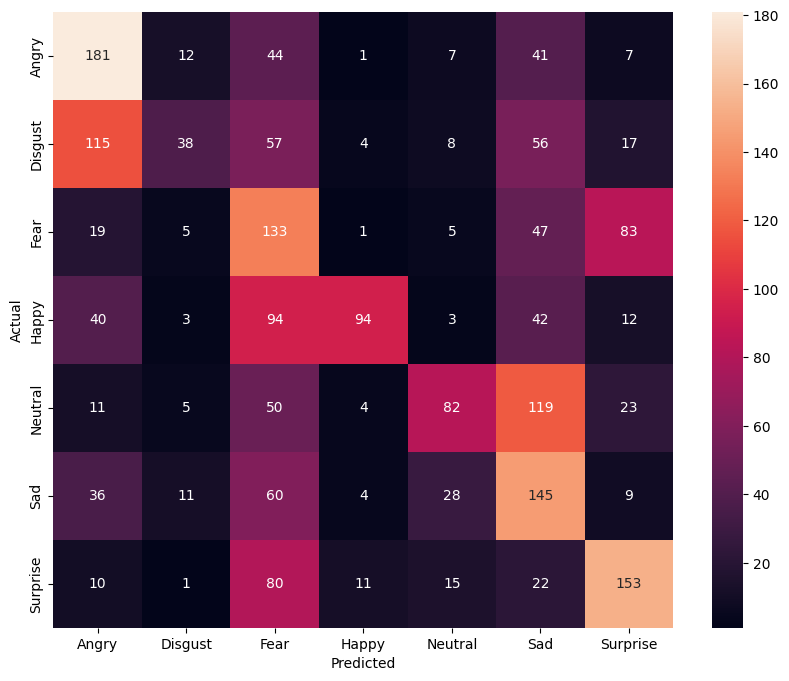

In [34]:
# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Print the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Test with images

In [58]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the colors for each emotion
emotions = {
    0: ['Angry', (0,0,255)],
    1: ['Disgust', (0,102,0)],
    2: ['Fear', (255,255,153)],
    3: ['Happy', (153,0,153)],
    4: ['Sad', (255,0,0)],
    5: ['Surprise', (0,255,0)],
    6: ['Neutral', (160,160,160)]
}

# Load the image
image = cv2.imread("C:/Users/darks/Downloads/faces3.jpg")

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

# Loop through each detected face
for (x, y, w, h) in faces:
    # Extract the face ROI from the original image
    face_image = image[y:y+h, x:x+w]

    # Resize the face ROI to 48x48 pixels
    resized_image = cv2.resize(face_image, (48, 48))

    # Convert the resized image to grayscale
    normalized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    normalized_image = normalized_image.astype('float32')

    # Make a prediction on the normalized image using the loaded model
    predictions = model.predict(np.expand_dims(normalized_image, axis=0))

    # Get the index of the highest predicted class
    predicted_class_index = np.argmax(predictions)

    # Print the predicted emotion class and its corresponding probability
    predicted_class = emotion_classes[predicted_class_index]
    predicted_probability = predictions[0][predicted_class_index]
    print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

    # Get the color for the predicted emotion
    color = emotions[predicted_class_index][1]

    # Draw a rectangle around the detected face with the corresponding color
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

    # Display the predicted emotion class and its corresponding probability on the image
    text = f"{predicted_class} ({predicted_probability:.2f})"
    cv2.putText(image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Resize the image to 1800x1200 pixels
image = cv2.resize(image, (1800, 1200))

# Display the image with the detected faces and their predictions
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 0s 23ms/step
Predicted emotion class: sad, probability: 0.7985390424728394
1/1 [==============================] - 0s 27ms/step
Predicted emotion class: surprise, probability: 0.9998112320899963
1/1 [==============================] - 0s 31ms/step
Predicted emotion class: fear, probability: 0.7220748662948608
1/1 [==============================] - 0s 22ms/step
Predicted emotion class: sad, probability: 0.6166070103645325
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: happy, probability: 0.9918322563171387
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: angry, probability: 0.9947086572647095
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: angry, probability: 0.9716494083404541
1/1 [==============================] - 0s 23ms/step
Predicted emotion class: sad, probability: 0.9391486048698425
1/1 [==============================] - 0s 21ms/step
Predicted emotion class:

In [31]:
import os
import cv2

# model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

class_labels=['Angry', 'Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [41]:


folder = "C:/Users/darks/Desktop/Emotion AI/DeepFace/dataset/Gianmarco/Emotions/"

for filename in os.listdir(folder):
    # Load the image
    frame = cv2.imread(os.path.join(folder, filename))
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces= face_classifier.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:

        sub_face_img=gray[y:y+h, x:x+w]
        resized=cv2.resize(sub_face_img,(48,48))
        normalize=resized
        reshaped=np.reshape(normalize, (1, 48, 48, 1))
        result=model.predict(reshaped)
        label=np.argmax(result, axis=1)[0]
        print(label)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 1)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(50,50,255),2)
        cv2.rectangle(frame,(x,y-40),(x+w,y),(50,50,255),-1)
        cv2.putText(frame, class_labels[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2.imshow("Frame", cv2.resize(frame, (1200, 1000)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 22ms/step
5
1/1 [==============================] - 0s 23ms/step
6
1/1 [==============================] - 0s 22ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 23ms/step
0
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 21ms/step
6
1/1 [==============================] - 0s 20ms/step
4
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 20ms/step
3
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 21ms/step
4
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 21ms/step
4
1/1 [=======================

# Video

In [61]:
import cv2
import numpy as np
from keras.models import load_model

# Load the pre-trained model
# model = load_model('Sequential_50e.h5')

# Define the emotion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the colors for each emotion
emotions = {
    0: ['Angry', (0,0,255)],
    1: ['Disgust', (0,102,0)],
    2: ['Fear', (255,255,153)],
    3: ['Happy', (153,0,153)],
    4: ['Sad', (255,0,0)],
    5: ['Surprise', (0,255,0)],
    6: ['Neutral', (160,160,160)]
}

# Create a VideoCapture object to capture frames from the webcam
video_capture = cv2.VideoCapture(0)

while True:
    # Capture a frame from the webcam
    ret, frame = video_capture.read()

    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_frame, 1.3, 5)

    # Loop through each detected face
    for (x, y, w, h) in faces:
        # Extract the face ROI from the original frame
        face_image = frame[y:y+h, x:x+w]

        # Resize the face ROI to 48x48 pixels
        resized_image = cv2.resize(face_image, (48, 48))

        # Convert the resized image to grayscale
        normalized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        normalized_image = normalized_image.astype('float32')

        # Make a prediction on the normalized image using the loaded model
        predictions = model.predict(np.expand_dims(normalized_image, axis=0))

        # Get the index of the highest predicted class
        predicted_class_index = np.argmax(predictions)

        # Print the predicted emotion class and its corresponding probability
        predicted_class = emotion_classes[predicted_class_index]
        predicted_probability = predictions[0][predicted_class_index]
        print(f"Predicted emotion class: {predicted_class}, probability: {predicted_probability}")

        # Get the color for the predicted emotion
        color = emotions[predicted_class_index][1]

        # Draw a rectangle around the detected face with the corresponding color
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

        # Display the predicted emotion class and its corresponding probability on the frame
        text = f"{predicted_class} ({predicted_probability:.2f})"
        cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Display the frame with the detected faces and their predictions
    cv2.imshow("Webcam", frame)

    # Check if the user pressed the 'q' key to quit the program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close all windows
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
Predicted emotion class: fear, probability: 0.6552807688713074
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fear, probability: 0.7833343744277954
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: fear, probability: 0.9380834698677063
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: fear, probability: 0.9530553221702576
1/1 [==============================] - 0s 19ms/step
Predicted emotion class: fear, probability: 0.8754827976226807
1/1 [==============================] - 0s 21ms/step
Predicted emotion class: fear, probability: 0.8754827976226807
1/1 [==============================] - 0s 25ms/step
Predicted emotion class: fear, probability: 0.6696915030479431
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fear, probability: 0.8481820821762085
1/1 [==============================] - 0s 20ms/step
Predicted emotion class: fea